In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import pyarrow

projectRoot = Path().resolve().parent
sys.path.append(str(projectRoot))

dataPath = projectRoot / 'data' / 'raw' / 'e_commerce_shopper_behaviour_and_lifestyle.csv'
df_raw = pd.read_csv(dataPath)
df = df_raw.copy()

In [2]:
# separating numerical and categorical features
numerical_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=('object')).columns.tolist()

# target variable
target = 'monthly_spend'

# numeric features excluding the target variable
numeric_features = [c for c in numerical_cols if c != target]

# datetime conversion
df['last_purchase_date'] = pd.to_datetime(
    df['last_purchase_date'], 
    format = '%Y-%m-%d'
)

In [3]:
# one-hot encoding -> only applied to categorical columns with low cardinality
low_cardinality_cat_columns = [
    c for c in categorical_cols
    if df[c].nunique() <= 6
]
print(low_cardinality_cat_columns)

df = pd.get_dummies(
    df,
    drop_first = True,
    columns = low_cardinality_cat_columns
)


['gender', 'urban_rural', 'employment_status', 'education_level', 'relationship_status', 'ethnicity', 'language_preference', 'device_type', 'preferred_payment_method', 'shopping_time_of_day', 'budgeting_style']


In [4]:
### Composite Score columns
composite_list = []
composite_columns = {}
# customer wellbeing columns
wellbeing_cols = [
    c for c in df.columns
    if 'stress' in c.lower() or 'mental' in c.lower() or 'emotional' in c.lower() or 'health' in c.lower() or 'physical' in c.lower() or 'sleep' in c.lower()
]
print(f'Wellbeing Columns: {wellbeing_cols}')
df['wellbeing_score'] = df[wellbeing_cols].mean(axis=1)
composite_list.append('wellbeing_score')
composite_columns['wellbeing_score'] = wellbeing_cols

# shopping engagement columns
shopping_engagement_cols = [
    c for c in df.columns
    if 'time' in c.lower() or 'brows' in c.lower()
]
print(f'Shopping Engagement Columns: {shopping_engagement_cols}')
df['shopping_engagement_score'] = df[shopping_engagement_cols].mean(axis=1)
composite_list.append('shopping_engagement_score')
composite_columns['shopping_engagement_score'] = shopping_engagement_cols

# price awareness columns
price_awareness_cols = [
    c for c in df.columns
    if 'coupon' in c.lower() or 'notification' in c.lower() or 'discount' in c.lower() or 'ad_' in c.lower()
]
print(f'Price Awareness Columns: {price_awareness_cols}')
df['price_awareness_score'] = df[price_awareness_cols].mean(axis=1)
composite_list.append('price_awareness_score')
composite_columns['price_awareness_score'] = price_awareness_cols

# impulse purchase -> Impulse vs Planned shopping behavior
impulse_purchase_cols = [
    c for c in df.columns
    if 'impulse' in c.lower()
]
print(f'Impulse Purchase Columns: {impulse_purchase_cols}')
df['impulse_purchase_score'] = df[impulse_purchase_cols].mean(axis=1)
df['planned_purchase_score'] = 10 - df['impulse_purchase_score']
composite_list.append('impulse_purchase_score')
composite_columns['impulse_purchase_score'] = impulse_purchase_cols

# review influence
review_influence_cols = [
    c for c in df.columns
    if 'review' in c.lower() or 'social' in c.lower() or 'reading' in c.lower()
]
print(f'Review Influence Columns: {review_influence_cols}')
df['review_influence_score'] = df[review_influence_cols].mean(axis=1)
composite_list.append('review_influence_score')
composite_columns['review_influence_score'] = review_influence_cols

# shopping funnel behavior
shopping_funnel_cols = [
    c for c in df.columns
    if 'cart' in c.lower() or 'order' in c.lower() or 'wishlist' in c.lower() or 'checkout' in c.lower() or 'purchase_conversion' in c.lower()
]
print(f'Shopping Funnel Columns: {shopping_funnel_cols}')
df['shopping_funnel_score'] = df[shopping_funnel_cols].mean(axis=1)
composite_list.append('shopping_funnel_score')
composite_columns['shopping_funnel_score'] = shopping_funnel_cols

Wellbeing Columns: ['environmental_consciousness', 'health_conscious_shopping', 'stress_from_financial_decisions', 'overall_stress_level', 'sleep_quality', 'physical_activity_level', 'mental_health_score']
Shopping Engagement Columns: ['browse_to_buy_ratio', 'daily_session_time_minutes', 'shopping_time_of_day_Evening', 'shopping_time_of_day_Morning', 'shopping_time_of_day_Night']
Price Awareness Columns: ['coupon_usage_frequency', 'ad_views_per_day', 'ad_clicks_per_day', 'notification_response_rate']
Impulse Purchase Columns: ['impulse_purchases_per_month', 'impulse_buying_score']
Review Influence Columns: ['review_writing_frequency', 'social_media_influence_score', 'reading_habits', 'social_sharing_frequency']
Shopping Funnel Columns: ['cart_abandonment_rate', 'average_order_value', 'wishlist_items_count', 'cart_items_average', 'checkout_abandonments_per_month', 'purchase_conversion_rate']


#### Validating Composite Scores

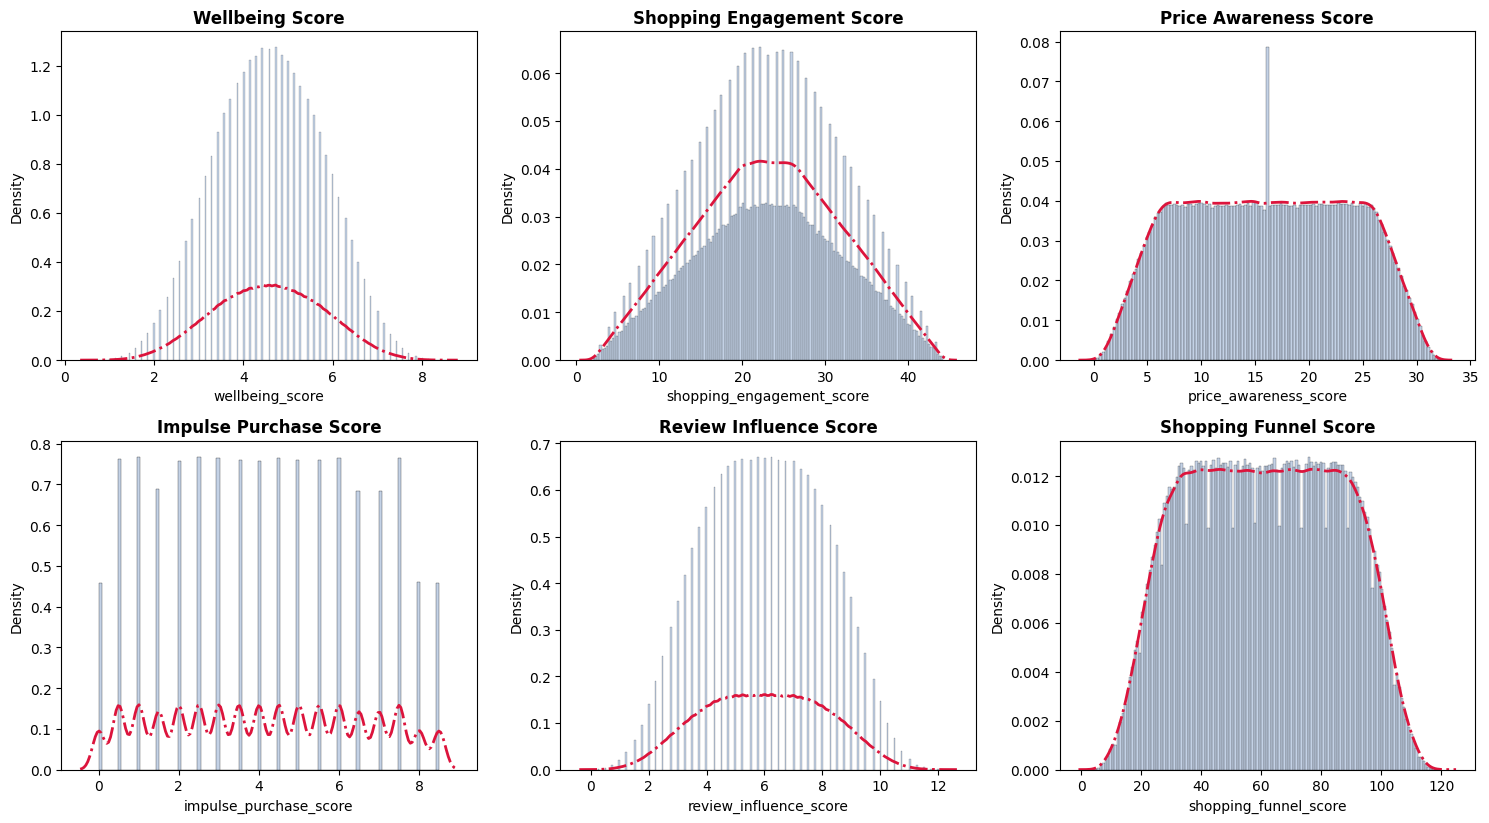

In [5]:
#### Validating composite scores - Distribution Check
n = len(composite_list)
cols = 3 
rows = int(np.ceil(n/2))

fig, axes = plt.subplots(
    rows,
    cols,
    figsize = (
        cols * 5,
        rows * 4
    )
)
axes = axes.flatten()

for ax, col in zip(axes, composite_list):
    sns.histplot(
        df[col],
        ax = ax,
        color = 'lightsteelblue',
        stat = 'density'
    )

    sns.kdeplot(
        df[col],
        ax = ax,
        color = 'crimson',
        linewidth = 2,
        linestyle = '-.'
    )

    ax.set_title(col.upper().replace('_', ' ').title(), fontweight = 'bold')

# remove empty plots in case the composite score list is odd number
for ax in axes[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

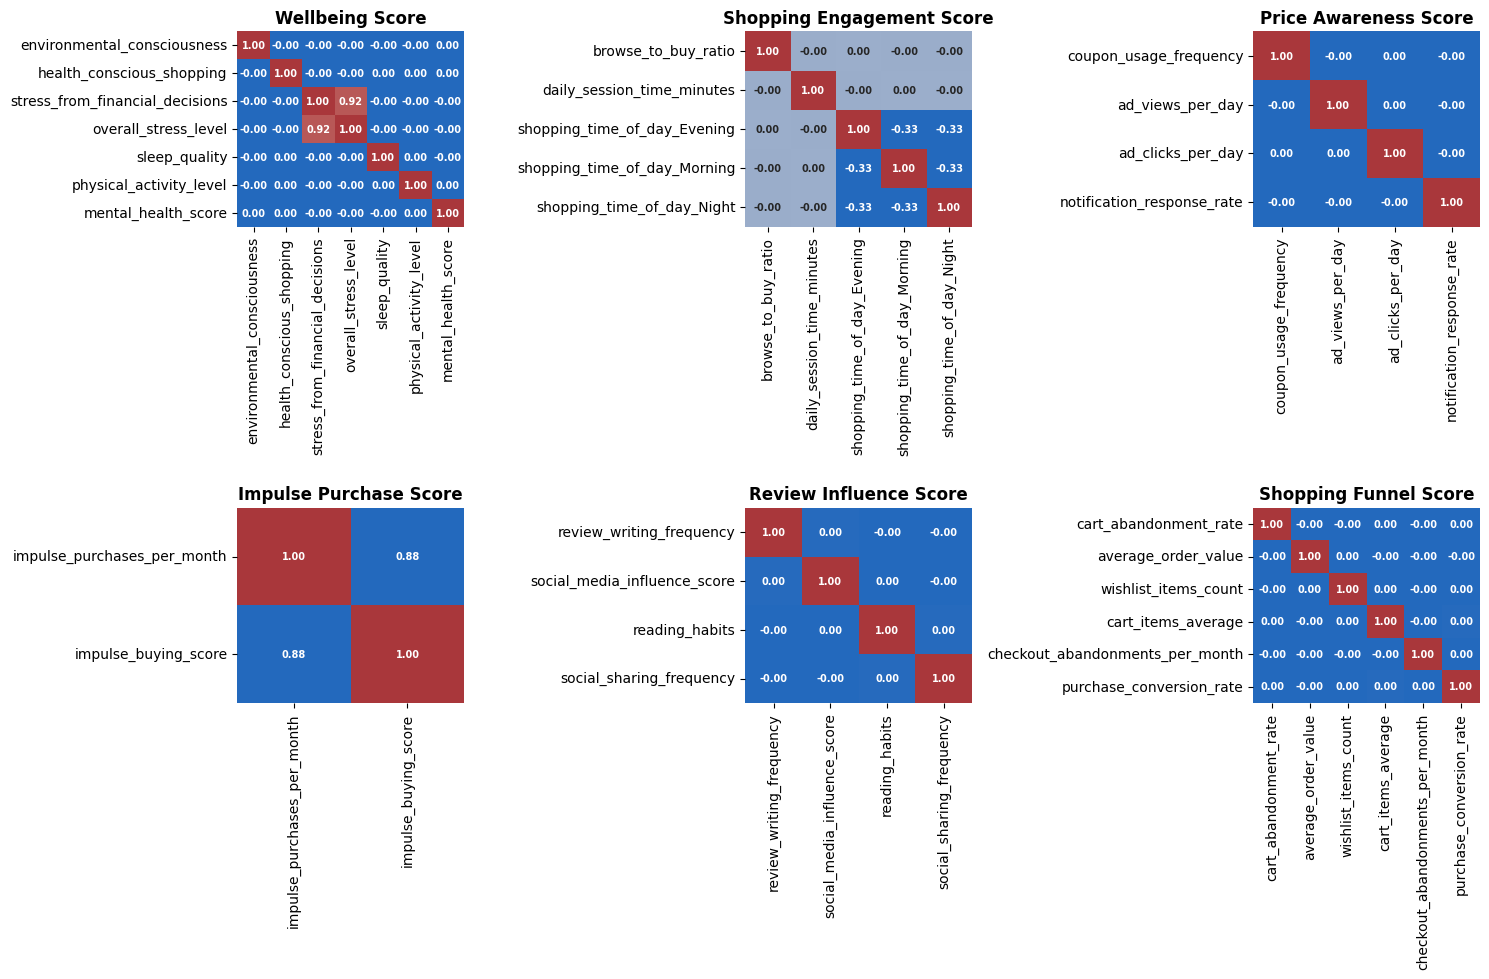

In [6]:
### Validating composite scores - Correlation among Components
n = len(composite_list)
cols = 3 
rows = int(np.ceil(n/2))

fig, axes = plt.subplots(
    rows,
    cols,
    figsize = (
        cols * 5,
        rows * 4
    )
)
axes = axes.flatten()

# converting bool values in the composite score dictionary into integers
df_imputed = df.copy()

for k in composite_columns.keys():
    for col in composite_columns[k]:
        if col in df_imputed.columns and df_imputed[col].dtype == bool:
            df_imputed[col] = df_imputed[col].astype(int)
        elif col in df_imputed.columns and df_imputed[col].dtype == str:
            df_imputed[col] = df_imputed[col].map({'False':0, 'True': 1})

# visualizing correlation heatmaps
for ax, col in zip(axes, composite_list):
    sns.heatmap(
        df_imputed[composite_columns[col]].corr(),
        ax = ax,
        #color = 'lightsteelblue',
        cmap = 'vlag',
        cbar = False,
        fmt = '.2f',
        annot = True,
        annot_kws = {
            'size': 7,
            'weight': 'bold'
        }
    )

    ax.set_title(col.upper().replace('_', ' ').title(), fontweight = 'bold')

# remove empty plots in case the composite score list is odd number
for ax in axes[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [7]:
### Validating composite scores - Predictive Contribution
"""To check the feature importance by Decision Tree whether the composite is more informative than raw features"""

def evaluate_composite_with_decision_tree(
        df,
        target,
        composite_name,
        raw_cols,
        max_depth = 3,
        min_samples_leaf = 50
):
    """
    Compare DecisionTreeRegressor performance and importances between raw components and composite features
    """
    results = {}

    # Raw features
    X_raw = df[raw_cols]
    y = df[target]

    tree_raw = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=7
    )
    tree_raw.fit(X_raw, y)

    results['raw'] = {
        'features': raw_cols,
        'importances': tree_raw.feature_importances_,
        'r2': tree_raw.score(X_raw, y)
    }

    # Composite features
    X_comp = df[[composite_name]]
    y = df[target]

    tree_composite = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=7
    )
    tree_composite.fit(X_comp, y)

    results['composite'] = {
        'features': composite_name,
        'importances': tree_composite.feature_importances_,
        'r2': tree_composite.score(X_comp, y)
    }

    return results

# iterating over all composite scores
tree_results = {}

for composite, raw_cols in composite_columns.items():
    
    tree_results[composite] = evaluate_composite_with_decision_tree(
        df = df_imputed,
        target=target,
        composite_name=composite,
        raw_cols=raw_cols,
        max_depth=5,
        min_samples_leaf=50
    )

In [8]:
# interpreting feature importances
for composite, result in tree_results.items():
    
    raw_importances = pd.Series(
        result['raw']['importances'],
        index = result['raw']['features']
    ).sort_values(ascending=False)
    
    print(f'--- {composite.upper()}---')
    print()
    print('Raw feature importances:')
    print(raw_importances)
    print()
    print(f"Raw R²: {result['raw']['r2']:.6f}")
    print(f"Composite R²: {result['composite']['r2']:.6f}")
    print()

--- WELLBEING_SCORE---

Raw feature importances:
stress_from_financial_decisions    0.170815
mental_health_score                0.169338
physical_activity_level            0.162518
health_conscious_shopping          0.158784
environmental_consciousness        0.148316
overall_stress_level               0.131581
sleep_quality                      0.058649
dtype: float64

Raw R²: 0.000153
Composite R²: 0.000033

--- SHOPPING_ENGAGEMENT_SCORE---

Raw feature importances:
browse_to_buy_ratio             0.485445
daily_session_time_minutes      0.366000
shopping_time_of_day_Morning    0.089711
shopping_time_of_day_Evening    0.047261
shopping_time_of_day_Night      0.011584
dtype: float64

Raw R²: 0.000119
Composite R²: 0.000057

--- PRICE_AWARENESS_SCORE---

Raw feature importances:
notification_response_rate    0.399143
ad_views_per_day              0.397194
ad_clicks_per_day             0.113321
coupon_usage_frequency        0.090341
dtype: float64

Raw R²: 0.000130
Composite R²: 0.00003

In [9]:
# ranking of composite scores based on decision tree regressor
summary = []
for composite, result in tree_results.items():
    summary.append({
        'composite': composite,
        'raw_r2': result['raw']['r2'],
        'composite_r2': result['composite']['r2']
    })

summary_df = pd.DataFrame(
    summary
).sort_values(by='composite_r2', ascending=False)

summary_df

,composite,raw_r2,composite_r2
1,shopping_engagement_score,0.000119,0.000057
5,shopping_funnel_score,0.000203,0.000035
3,impulse_purchase_score,0.000041,0.000035
0,wellbeing_score,0.000153,0.000033
4,review_influence_score,0.000117,0.000032
2,price_awareness_score,0.000130,0.000032


Neither raw features nor composites explain the variance in target variable 'monthly_spend' by themselves. This implies that the target variable is highly noisy, and cannot be predicted from any single behavioral pattern. These findings motivate the use of interaction features, segmentation approaches, and ensemble models in subsequent modeling steps.

In [10]:
### scaling the final feature table before saving 
# dropping categorical columns if any exists in the dataframe
df_imputed_num = df_imputed.copy()
cols_to_drop = [c for c in categorical_cols if c in df_imputed_num.columns]
df_imputed_num = df_imputed_num.drop(columns = cols_to_drop)

# converting datetime/period columns
for col in df_imputed_num.columns:
    dtype = df_imputed_num[col].dtype

    if isinstance(dtype, pd.PeriodDtype):
        df_imputed_num[col] = df_imputed_num[col].astype(str)

    elif pd.api.types.is_datetime64_any_dtype(df_imputed_num[col]):
        df_imputed_num[col] = df_imputed_num[col].astype('datetime64[ns]')

# scaling the final data
scl = StandardScaler()

scaler_cols = [
    c for c in df_imputed_num.columns
    if c not in [target] and df_imputed_num[c].dtype != 'uint8'
]

df_imputed_num[scaler_cols] = scl.fit_transform(df_imputed_num[scaler_cols])
df_imputed_num.shape

# saving to destination folder
outputPath = projectRoot / 'data' / 'processed' 
outputPath.parent.mkdir(parents=True,exist_ok=True)
parquetPath = outputPath / 'features_with_composites.parquet'

df_imputed_num.to_parquet(
    parquetPath, 
    engine = 'pyarrow',
    compression = 'snappy',
    index=False
)